# Notebook for paper

## Settings

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals;

#imports
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot, lag_plot
pd.set_option('max_columns', 150)
import os,random, math, psutil, pickle
import gc
from scipy import stats
from scipy.stats import skew
import math
import warnings
import time

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import missingno as msno

import seaborn as sns
#sns.set(style="whitegrid")

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
%matplotlib inline

#plt.rcParams['figure.figsize'] = (10, 8) # set default size of plots
#plt.rcParams['image.interpolation'] = 'nearest'
#plt.rcParams['image.cmap'] = 'gray'

# Interactivity
from ipywidgets import interact, widgets
from sklearn.tree import export_graphviz
from IPython.display import Image

# Plotly
import plotly.graph_objs as go
from plotly.offline import iplot, plot, init_notebook_mode
init_notebook_mode(connected=True)
import plotly_express as px
from plotly import tools, subplots
import plotly.offline as py

# cufflinks is a wrapper on plotly
import cufflinks as cf
cf.go_offline(connected=True)

 # sklearn
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit, StratifiedKFold, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
import lightgbm as lgb
from sklearn.base import BaseEstimator
from sklearn.ensemble import GradientBoostingRegressor


# deep learning
import tensorflow as tf

# time series
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.gofplots import qqplot

# to make this notebook's output stable across runs
np.random.seed(42)

# Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [2]:
def rmse(y_true, y_pred):
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true), axis=-1)) 

## Loading data

In [3]:
# loading the data from onedrive
# change the name for different house
data_c32 = pd.read_csv('C:/Users/al146/OneDrive - Heriot-Watt University/PhD/Data/Findhorn/test/C32_15Feb2015_28Mar2015.csv', names=['date', 'time', 'meter_reading'], skiprows=1)
data_c32["timestamp"] = data_c32["date"] + " " + data_c32["time"].astype(str)
data_c32['timestamp'] = pd.to_datetime(data_c32['timestamp'], errors='raise', infer_datetime_format=True)
data_c32 = data_c32.drop(['time', 'date'], axis=1)
data_c32['site_id'] = 'c32'

In [4]:
# Loading data (Reading and cleaning the files)

data_df = reduce_mem_usage(data_c32.copy())
del data_c32

data_df['site_id'] = data_df['site_id'].astype('str')
data_df['timestamp'] = pd.to_datetime(data_df['timestamp'], errors='raise')

# replace negative values with a small number
data_df['meter_reading'].mask(data_df['meter_reading'] <= 0, 0.09, inplace=True)

data_df.drop(data_df.columns[2], axis=1, inplace=True)

Mem. usage decreased to  0.21 Mb (25.0% reduction)


In [5]:
data_df.head()

,meter_reading,timestamp
0,0.101196,2015-02-15 00:00:00
1,0.069214,2015-02-15 00:05:00
2,0.069458,2015-02-15 00:10:00
3,0.069458,2015-02-15 00:15:00
4,0.124451,2015-02-15 00:20:00


In [6]:
df = data_df.rename(columns = {'timestamp': 'ds', 'meter_reading': 'ts'})
df = df.groupby(by = 'ds').agg({'ts': 'mean'})
df.index = pd.to_datetime(df.index)
df = df.asfreq(freq='5T')
df = df.sort_index(ascending = True)
df = df.fillna(value = 0)

#### Moving average and other transformation (Power transformation)

# Transformation - log ts
df['ts_log'] = df['ts'].apply(lambda x: np.log(x))

# Transformation - ts diff
df['ts_diff'] = df['ts'] - df['ts'].shift()

# # Transformation - log ts
df['ts_sqrt'] = df['ts'].apply(lambda x: np.sqrt(x))

# Transformation - Difference between logged ts and first-order difference logged ts
df['ts_log_diff'] = df['ts_log'] - df['ts_log'].shift()
df['ts_log_diff'] = df['ts_log'].diff()

# Transformation - Difference between logged ts and logged moving average ts
df = df.dropna()

## Charts

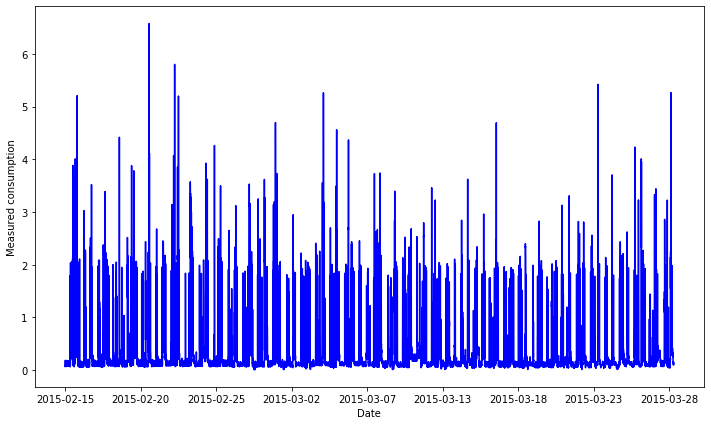

In [7]:
plt.figure(figsize=(12,7))
plt.plot(df.index, df.ts, label='Energy Consumption', color='blue')
plt.xticks(df.index[::1500])
plt.ylabel('Measured consumption')
plt.xlabel('Date')
plt.savefig('graph.png')
plt.show()

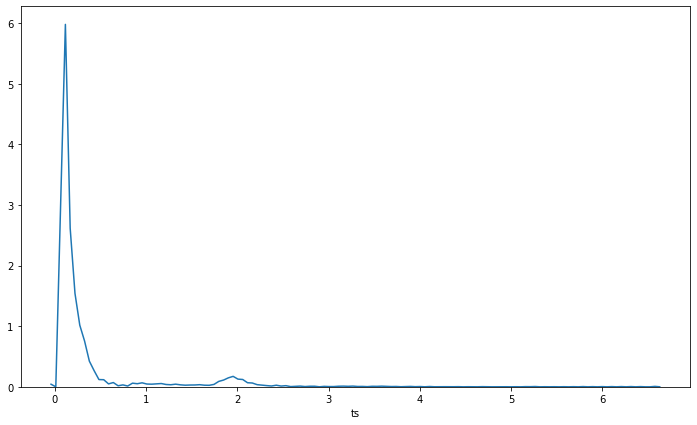

In [8]:
plt.figure(figsize=(12,7))
sns.distplot(df.ts, hist=False)

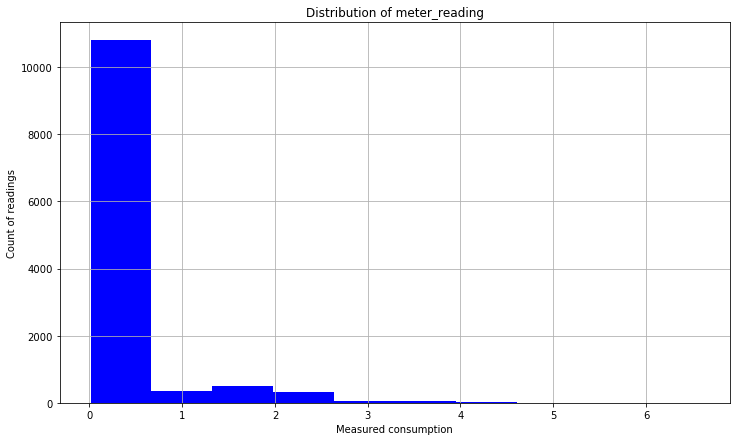

In [9]:
plt.figure(figsize=(12,7))

df['ts'].hist(color='blue')
plt.title('Distribution of meter_reading')
plt.ylabel("Count of readings")
plt.xlabel(f"Measured consumption")
plt.show()

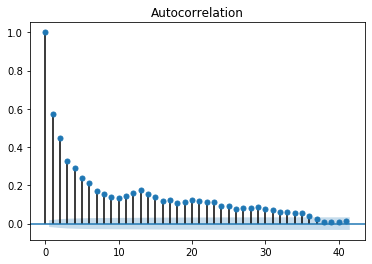

<Figure size 864x504 with 0 Axes>

In [10]:
plot_acf(df['ts'])
plt.figure(figsize=(12,7))
plt.show()

## Persistence Model

In [39]:
values = pd.DataFrame(data_df['meter_reading'].values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
print(dataframe.head(5))

          t       t+1
0       NaN  0.101196
1  0.101196  0.069214
2  0.069214  0.069458
3  0.069458  0.069458
4  0.069458  0.124451


In [40]:
def model_persistence(x):
	return x

X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)

mae = mean_absolute_error(test_y, predictions)
mse = mean_squared_error(test_y, predictions)
rmse = np.sqrt(mse)

print('MAE: %f' % mae)
print('MSE: %f' % mse)
print('RMSE: %f' % rmse)

MAE: 0.165894
MSE: 0.241211
RMSE: 0.491211


## ARIMA

In [41]:
def run_arima_model(df, ts, p, d, q):
    """
    Run ARIMA model
    p is the number of lags
    """

    # fit ARIMA model on time series
    model = ARIMA(df[ts], order=(p, d, q))  
    results_ = model.fit(disp=-1)  

    # get lengths correct to calculate RSS
    len_results = len(results_.fittedvalues)
    ts_modified = df[ts][-len_results:]

    # calculate root mean square error (RMSE) and residual sum of squares (RSS)
    rss = sum((results_.fittedvalues - ts_modified)**2)
    rmse = np.sqrt(rss / len(df[ts]))
    mse = rss / len(df[ts])

    # plot fit
    plt.figure(figsize=(12,7))
    plt.plot(df[ts])
    plt.plot(results_.fittedvalues, color = 'red')
    plt.title('For ARIMA model (%i, %i, %i), RMSE: %.4f' %(p, d, q, rmse))

    plt.show()
    plt.close()
    
    print(rmse)
    print(mse)

    return results_

                              ARMA Model Results                              
Dep. Variable:          meter_reading   No. Observations:                12097
Model:                     ARMA(1, 1)   Log Likelihood               -8008.263
Method:                       css-mle   S.D. of innovations              0.469
Date:                Sat, 13 Jun 2020   AIC                          16024.527
Time:                        10:19:45   BIC                          16054.130
Sample:                             0   HQIC                         16034.453
                                                                              
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.3378      0.013     25.529      0.000       0.312       0.364
ar.L1.meter_reading     0.7815      0.010     81.401      0.000       0.763       0.800
ma.L1.meter_read

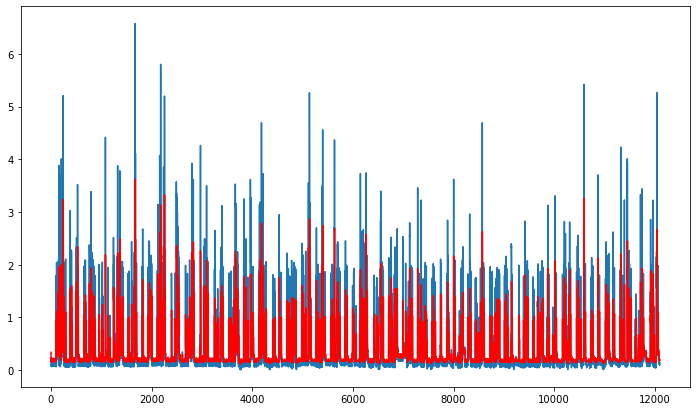

In [12]:
# fit ARIMA model on time series
model = ARIMA(data_df['meter_reading'], order=(1, 0, 1))  
results_ = model.fit(disp=0)  

print(results_.summary())

# get lengths correct to calculate RSS
len_results = len(results_.fittedvalues)
ts_modified = data_df['meter_reading'][-len_results:]

# plot fit
plt.figure(figsize=(12,7))
plt.plot(data_df['meter_reading'])
plt.plot(results_.fittedvalues, color = 'red')

plt.show()
plt.close()

<Figure size 864x504 with 0 Axes>

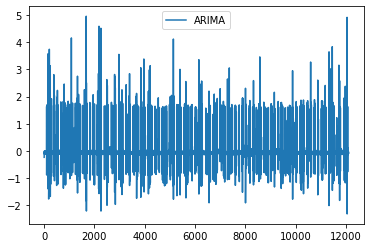

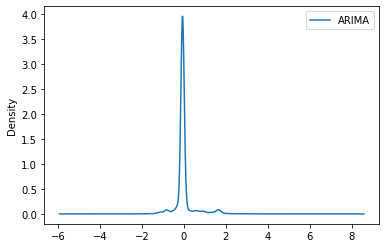

              ARIMA
count  12097.000000
mean       0.000024
std        0.469114
min       -2.317327
25%       -0.093453
50%       -0.075888
75%       -0.034784
max        4.951094


In [13]:
# plot residual errors
residuals = pd.DataFrame(results_.resid, columns=['ARIMA'])
plt.figure(figsize=(12,7))
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

expected = data_df['meter_reading']
predictions = results_.fittedvalues

mae = mean_absolute_error(expected, predictions)
mse = mean_squared_error(expected, predictions)
rmse = np.sqrt(mse)

print('MAE: %f' % mae)
print('MSE: %f' % mse)
print('RMSE: %f' % rmse)

MAE: 0.221980
MSE: 0.220050
RMSE: 0.469095


## Random Forest regressor

In [15]:
def rf_data(df, ts, look_back=1, train_fraction=0.80, Scaler=None):
    """
    Create data for modelling
    """

    # Convert an array of values into a dataset matrix
    def create_dataset(dataset, look_back=1):
        """
        Create the dataset
        """
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
        return np.array(dataX), np.array(dataY)
    
    # Get dataset
    dataset = df[ts].values
    dataset = dataset.astype('float32')
    
    # Normalize the dataset
    #dataset = scaler.fit_transform(dataset.reshape(-1, 1))
    dataset = dataset.reshape(-1, 1)
    
    # Split into train and test sets
    train_size = int(len(dataset) * train_fraction)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
  
    # Reshape into X=t and Y=t+1
    look_back = look_back
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    
    return trainX, trainY, testX, testY, dataset

In [16]:
# Initiate scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# window size
lag = 35

trainX, trainY, testX, testY, dataset = rf_data(df=data_df, ts='meter_reading', look_back=lag, train_fraction=0.80, Scaler=scaler)

In [17]:
%%time

tscv = TimeSeriesSplit(n_splits=5)

# Perform Grid-Search for finding best parameters
gsc = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid={
        'max_depth': range(5, 10, 15),
        'n_estimators': (50, 100, 1000),
        #'bootstrap': [False, True],
        'max_features': [5, 10, 15, 20, 35]
    },
    cv=tscv, scoring='neg_root_mean_squared_error', verbose=0)
    
grid_result = gsc.fit(trainX, trainY)
best_params = grid_result.best_params_

Wall time: 9min 29s


In [18]:
# Perform cross validation

rfr = RandomForestRegressor(max_depth=best_params['max_depth'], n_estimators=best_params['n_estimators'], bootstrap=True,
                            max_features=best_params['max_features'], random_state=False, verbose=0)

scores = -1 * cross_val_score(rfr, trainX, trainY, cv=tscv, scoring='neg_root_mean_squared_error')

print("Best estimator:\n{}", format(best_params))
print("Best cross-validation score (RMSE): ", format(-1 * grid_result.best_score_))
print('Cross-validated score (RMSE) for each fold:', '\n', scores)
print('Mean cross-validated score (RMSE): %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))
print("Variance of cross-validated score (RMSE):", scores.var())

Best estimator:
{} {'max_depth': 5, 'max_features': 20, 'n_estimators': 1000}
Best cross-validation score (RMSE):  0.4584670494341895
Cross-validated score (RMSE) for each fold: 
 [0.55258274 0.47076269 0.48924728 0.40438696 0.37386933]
Mean cross-validated score (RMSE): 0.46 (+/- 0.13)
Variance of cross-validated score (RMSE): 0.004007471437328863


In [19]:
rfr.fit(trainX, trainY)

trainPredict = rfr.predict(trainX)
testPredict = rfr.predict(testX)

In [20]:
mae = metrics.mean_absolute_error(trainY,trainPredict)
mse = metrics.mean_squared_error(trainY,trainPredict)
print ("TRAINING SET")
print ("============")
print ("MAE:                ", mae)
print ("MSE:                ", mse)
print ("RMSE:               ", math.sqrt(mse))


mae = metrics.mean_absolute_error(testY,testPredict)
mse = metrics.mean_squared_error(testY,testPredict)
print ("TEST SET")
print ("========")
print ("MAE:                ", mae)
print ("MSE:                ", mse)
print ("RMSE:               ", math.sqrt(mse))

TRAINING SET
MAE:                 0.20770318807597704
MSE:                 0.18351951300714375
RMSE:                0.42839177513946713
TEST SET
MAE:                 0.20565465010364123
MSE:                 0.19899419322276304
RMSE:                0.446087651950559


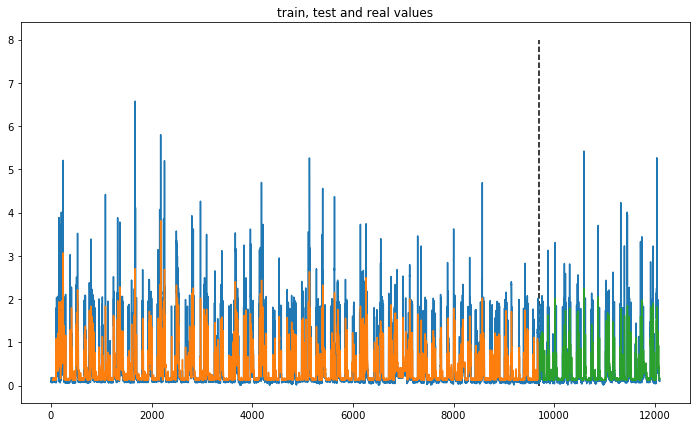

In [21]:
look_back = 35 
# Invert predictions
#trainPredict = scaler.inverse_transform(trainPredict.reshape(-1, 1))
trainPredict = trainPredict.reshape(-1, 1)
#testPredict = scaler.inverse_transform(testPredict.reshape(-1, 1))
testPredict = testPredict.reshape(-1, 1)

# Shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# # Shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

#actual_values = scaler.inverse_transform(dataset)
actual_values = dataset

# Plot baseline and predictions

plt.figure(figsize=(12,7))
plt.plot(actual_values)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.vlines(x=9687, ymin=0, ymax=8, colors='k', linestyles='dashed')
plt.title('train, test and real values')
plt.show()

In [22]:
actual_values = actual_values.flatten('F')
actual_values.reshape(-1, 1)
trainPredictPlot = trainPredictPlot.flatten('F')
trainPredictPlot.reshape(-1, 1)
testPredictPlot = testPredictPlot.flatten('F')
testPredictPlot.reshape(-1, 1)

array([[       nan],
       [       nan],
       [       nan],
       ...,
       [0.17646922],
       [0.17679699],
       [       nan]], dtype=float32)

In [23]:
error_distro = pd.DataFrame(np.vstack((actual_values, testPredictPlot)))
error_distro = error_distro.transpose() 
error_distro.columns=['actual_value','testPredict']

error_distro.drop(error_distro.index[0:9687], inplace=True)
error_distro.drop([12096], inplace=True)
error_distro['residuals'] = error_distro['actual_value'] - error_distro['testPredict']

count    2384.000000
mean       -0.006189
std         0.446138
min        -1.866676
25%        -0.108961
50%        -0.053552
75%        -0.027897
max         4.723522
Name: residuals, dtype: float64

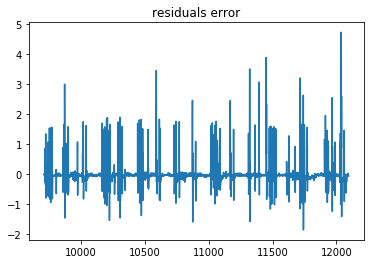

In [24]:
ax = sns.lineplot(data=error_distro['residuals'])
ax.set_title('residuals error')
error_distro['residuals'].describe()

Text(0.5, 1.0, 'Histogram Plot of Residual Errors')

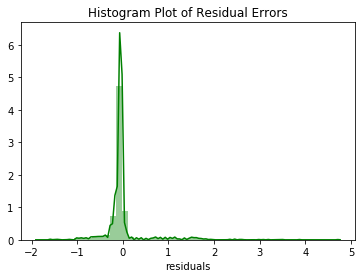

In [25]:
ax = sns.distplot(error_distro['residuals'], kde=True, color="g")
ax.set_title('Histogram Plot of Residual Errors')

In [26]:
residuals['RF'] = error_distro['residuals']

In [27]:
del error_distro, actual_values, trainPredictPlot, testPredictPlot

## LightGBM

In [42]:
train_df = pd.DataFrame(trainX, columns=['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12', 'm13', 'm14', 'm15', 'm16', 'm17', 'm18',
                                         'm19', 'm20', 'm21', 'm22', 'm23', 'm24', 'm25', 'm26', 'm27', 'm28', 'm29', 'm30', 'm31', 'm32', 'm33', 'm34', 'm35'])
target = pd.DataFrame(trainY, columns=['meter_reading'])

In [43]:
categorical_feat = []

numericals = ['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12', 'm13', 'm14', 'm15', 'm16', 'm17', 'm18',
              'm19', 'm20', 'm21', 'm22', 'm23', 'm24', 'm25', 'm26', 'm27', 'm28', 'm29', 'm30', 'm31', 'm32', 'm33', 'm34', 'm35']

feat_cols = numericals

In [44]:
params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'mse'},
            'subsample_freq': 10,
            'learning_rate': 0.001,
            'bagging_freq': 5,
            'num_leaves': 100,
            'feature_fraction': 0.9,
            'lambda_l1': 1,  
            'lambda_l2': 1
            }

folds = 5
seed = 666
shuffle = False
kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)

models = []

for train_index,test_index in kf.split(train_df[feat_cols]):
    train_features = train_df[feat_cols].loc[train_index]
    train_target = target.loc[train_index]
    
    test_features = train_df[feat_cols].loc[test_index]
    test_target = target.loc[test_index]
    
    d_training = lgb.Dataset(train_features, label=train_target, categorical_feature=categorical_feat, free_raw_data=False)
    d_test = lgb.Dataset(test_features, label=test_target, categorical_feature=categorical_feat, free_raw_data=False)
    
    model = lgb.train(params,
                      train_set=d_training,
                      num_boost_round=1000,
                      valid_sets=[d_training,d_test],
                      verbose_eval=500,
                      early_stopping_rounds=50)
    
    models.append(model)
    
    del train_features, train_target, test_features, test_target, d_training, d_test
    
    gc.collect()

C:\Python37\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 50 rounds
[500]	training's l2: 0.223854	valid_1's l2: 0.336685
[1000]	training's l2: 0.17051	valid_1's l2: 0.294705
Did not meet early stopping. Best iteration is:
[1000]	training's l2: 0.17051	valid_1's l2: 0.294705
Training until validation scores don't improve for 50 rounds
[500]	training's l2: 0.222975	valid_1's l2: 0.35115
[1000]	training's l2: 0.171045	valid_1's l2: 0.304233
Did not meet early stopping. Best iteration is:
[1000]	training's l2: 0.171045	valid_1's l2: 0.304233
Training until validation scores don't improve for 50 rounds
[500]	training's l2: 0.233367	valid_1's l2: 0.299426
[1000]	training's l2: 0.177568	valid_1's l2: 0.264977
Did not meet early stopping. Best iteration is:
[1000]	training's l2: 0.177568	valid_1's l2: 0.264977
Training until validation scores don't improve for 50 rounds
[500]	training's l2: 0.250126	valid_1's l2: 0.205081
[1000]	training's l2: 0.188313	valid_1's l2: 0.188331
Did not meet early stoppi

In [45]:
test_df = pd.DataFrame(testX, columns=['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12', 'm13', 'm14', 'm15', 'm16', 'm17', 'm18',
                                       'm19', 'm20', 'm21', 'm22', 'm23', 'm24', 'm25', 'm26', 'm27', 'm28', 'm29', 'm30', 'm31', 'm32', 'm33', 'm34', 'm35'])
testtarget = pd.DataFrame(testY, columns=['meter_reading'])

In [46]:
#prediction
trainPredict = []
for model in models:
    if  trainPredict == []:
        trainPredict = np.expm1(model.predict(trainX, num_iteration=model.best_iteration)) / len(models)
    else:
        trainPredict += np.expm1(model.predict(trainX, num_iteration=model.best_iteration)) / len(models)
    del model
    gc.collect()

In [47]:
#prediction
testPredict = []
for model in models:
    if  testPredict == []:
        testPredict = np.expm1(model.predict(testX, num_iteration=model.best_iteration)) / len(models)
    else:
        testPredict += np.expm1(model.predict(testX, num_iteration=model.best_iteration)) / len(models)
    del model
    gc.collect()

In [48]:
mae = metrics.mean_absolute_error(trainY,trainPredict)
mse = metrics.mean_squared_error(trainY,trainPredict)
print ("TRAINING SET")
print ("============")
print ("MAE:                ", mae)
print ("MSE:                ", mse)
print ("RMSE:               ", math.sqrt(mse))


mae = metrics.mean_absolute_error(testY,testPredict)
mse = metrics.mean_squared_error(testY,testPredict)
print ("TEST SET")
print ("========")
print ("MAE:                ", mae)
print ("MSE:                ", mse)
print ("RMSE:               ", math.sqrt(mse))

TRAINING SET
MAE:                 0.24556499812894622
MSE:                 0.1546466787972358
RMSE:                0.39325141932005253
TEST SET
MAE:                 0.27638390375717
MSE:                 0.22569436500114648
RMSE:                0.47507301017964226


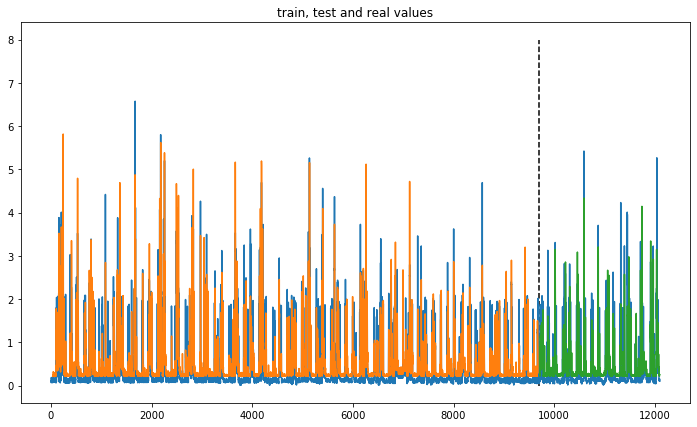

In [49]:
look_back = 35 
# Invert predictions
#trainPredict = scaler.inverse_transform(trainPredict.reshape(-1, 1))
trainPredict = trainPredict.reshape(-1, 1)
#testPredict = scaler.inverse_transform(testPredict.reshape(-1, 1))
testPredict = testPredict.reshape(-1, 1)

# Shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# # Shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

#actual_values = scaler.inverse_transform(dataset)
actual_values = dataset

# Plot baseline and predictions

plt.figure(figsize=(12,7))
plt.plot(actual_values)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.vlines(x=9687, ymin=0, ymax=8, colors='k', linestyles='dashed')
plt.title('train, test and real values')
plt.show()

In [50]:
actual_values = actual_values.flatten('F')
actual_values.reshape(-1, 1)
trainPredictPlot = trainPredictPlot.flatten('F')
trainPredictPlot.reshape(-1, 1)
testPredictPlot = testPredictPlot.flatten('F')
testPredictPlot.reshape(-1, 1)

array([[       nan],
       [       nan],
       [       nan],
       ...,
       [0.25609416],
       [0.25357208],
       [       nan]], dtype=float32)

In [51]:
error_distro = pd.DataFrame(np.vstack((actual_values, testPredictPlot)))
error_distro = error_distro.transpose() 
error_distro.columns=['actual_value','testPredict']

error_distro.drop(error_distro.index[0:9687], inplace=True)
error_distro.drop([12096], inplace=True)
error_distro['residuals'] = error_distro['actual_value'] - error_distro['testPredict']

count    2384.000000
mean       -0.107836
std         0.462769
min        -4.032189
25%        -0.187248
50%        -0.142692
75%        -0.113828
max         4.773469
Name: residuals, dtype: float64

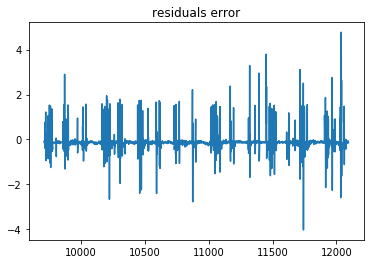

In [52]:
ax = sns.lineplot(data=error_distro['residuals'])
ax.set_title('residuals error')
error_distro['residuals'].describe()

Text(0.5, 1.0, 'Histogram Plot of Residual Errors')

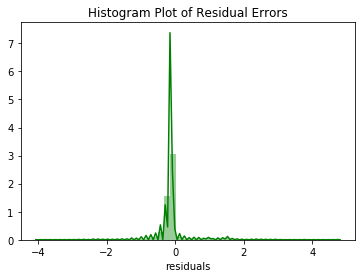

In [53]:
ax = sns.distplot(error_distro['residuals'], kde=True, color="g")
ax.set_title('Histogram Plot of Residual Errors')

In [54]:
residuals['LGBM'] = error_distro['residuals']

In [55]:
del error_distro, actual_values, trainPredictPlot, testPredictPlot

## Deep Neural Network

In [60]:
def nn_data(df, ts, look_back=1, train_fraction=0.80, Scaler=None):
    """
    Create data for modelling
    """

    # Convert an array of values into a dataset matrix
    def create_dataset(dataset, look_back=1):
        """
        Create the dataset
        """
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
        return np.array(dataX), np.array(dataY)
    
    # Get dataset
    dataset = df[ts].values
    dataset = dataset.astype('float32')
    
    # Normalize the dataset
    dataset = scaler.fit_transform(dataset.reshape(-1, 1))
    
    # Split into train and test sets
    train_size = int(len(dataset) * train_fraction)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
  
    # Reshape into X=t and Y=t+1
    look_back = look_back
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    
    return trainX, trainY, testX, testY, dataset

In [65]:
def nn_model(trainX, trainY, testX, testY, look_back, epochs, Scaler=None, dataset=None):
    """
    Create model
    """

    # Create and fit the network
    batch_size = 256
    model = tf.keras.models.Sequential()
    
    model.add(tf.keras.layers.Dense(15, activation='relu', input_dim=look_back))
    model.add(tf.keras.layers.Dense(10, activation='relu'))
    #model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(5, activation='relu'))

    model.add(tf.keras.layers.Dense(1, activation='relu'))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    
    model.compile(loss='mse', optimizer=optimizer, metrics=[rmse, 'mae'])

    early_stopping_monitor = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)
    history = model.fit(trainX, trainY, epochs = epochs, batch_size = batch_size, verbose = 0, validation_split=0.2, callbacks = [early_stopping_monitor])
    
    print('Loss (MSE):    ', history.history['loss'][-1], '\nVal_loss (MSE): ', history.history['val_loss'][-1])
    
    #score_rmse_train = model.evaluate(trainX, trainY)
    #print('Train Score (MSE, RMSE, MAE):', score_rmse_train)
    
    #score_rmse_test = model.evaluate(testX, testY)
    #print('Test Score (MS, RMSE, MAE):', score_rmse_test)
    
    # Make predictions
    trainPredict = model.predict(trainX, verbose=1)
    testPredict = model.predict(testX, verbose=1)

    
    # Invert predictions
    trainPredict = scaler.inverse_transform(trainPredict.reshape(-1, 1))
    trainY = scaler.inverse_transform(trainY.reshape(-1, 1))
    testPredict = scaler.inverse_transform(testPredict.reshape(-1, 1))
    testY = scaler.inverse_transform(testY.reshape(-1, 1))
    
    mae = metrics.mean_absolute_error(trainY,trainPredict)
    mse = metrics.mean_squared_error(trainY,trainPredict)
    print ("TRAINING SET")
    print ("============")
    print ("MAE:                ", mae)
    print ("MSE:                ", mse)
    print ("RMSE:               ", math.sqrt(mse))


    mae = metrics.mean_absolute_error(testY,testPredict)
    mse = metrics.mean_squared_error(testY,testPredict)
    print ("TEST SET")
    print ("========")
    print ("MAE:                ", mae)
    print ("MSE:                ", mse)
    print ("RMSE:               ", math.sqrt(mse))

    # Shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
  
    # Shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
  
    model.summary()
    
    # Plot baseline and predictions
    plt.plot(scaler.inverse_transform(dataset))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.vlines(x=9687, ymin=0, ymax=8, colors='k', linestyles='dashed')
    plt.title('train, test and real values')
    plt.show()
    
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
    # Plot training & validation accuracy values
    plt.plot(history.history['rmse'])
    plt.plot(history.history['val_rmse'])
    plt.title('Model accuracy')
    plt.ylabel('Error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    return trainPredictPlot, testPredictPlot

Loss (MSE):     0.0053375247958661115 
Val_loss (MSE):  0.0034146023059781387
2384/2384 [==============================] - 0s 19us/sample
TRAINING SET
MAE:                 0.2225931
MSE:                 0.21023796
RMSE:                0.4585171370709658
TEST SET
MAE:                 0.20948231
MSE:                 0.20608328
RMSE:                0.45396396644263626
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 15)                540       
_________________________________________________________________
dense_9 (Dense)              (None, 10)                160       
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 6         
Total params: 76

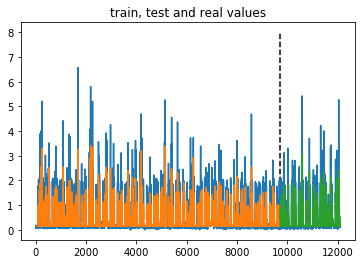

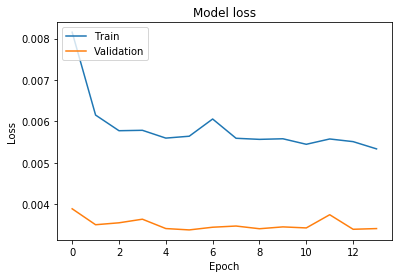

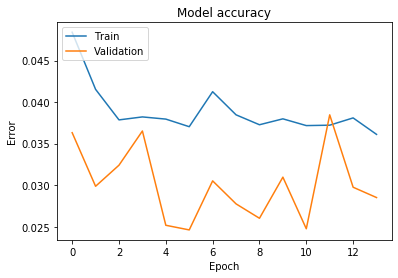

It takes  0.03  Min to train and test the model


In [66]:
# Initiate scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# window size
lag = 35

trainX, trainY, testX, testY, dataset = nn_data(df=data_df, ts='meter_reading', look_back=lag, train_fraction=0.80, Scaler=scaler)

# timing
tic = time.clock()

trainPredictPlot, testPredictPlot = nn_model(trainX=trainX, trainY=trainY, testX=testX, testY=testY, look_back=lag, epochs=200, Scaler=scaler, dataset=dataset)

toc = time.clock()
timeit = (toc - tic)/60
print('It takes ',str(round(timeit, 2)),' Min to train and test the model')

In [67]:
actual_values = dataset.flatten('F')
actual_values.reshape(-1, 1)
trainPredictPlot = trainPredictPlot.flatten('F')
trainPredictPlot.reshape(-1, 1)
testPredictPlot = testPredictPlot.flatten('F')
testPredictPlot.reshape(-1, 1)

array([[       nan],
       [       nan],
       [       nan],
       ...,
       [0.15501617],
       [0.19938993],
       [       nan]], dtype=float32)

In [68]:
error_distro = pd.DataFrame(np.vstack((actual_values, testPredictPlot)))
error_distro = error_distro.transpose() 
error_distro.columns=['actual_value','testPredict']

error_distro.drop(error_distro.index[0:9687], inplace=True)
error_distro.drop([12096], inplace=True)
error_distro['residuals'] = error_distro['actual_value'] - error_distro['testPredict']

count    2384.000000
mean       -0.268343
std         0.278300
min        -2.487346
25%        -0.290606
50%        -0.146612
75%        -0.139991
max         0.454471
Name: residuals, dtype: float64

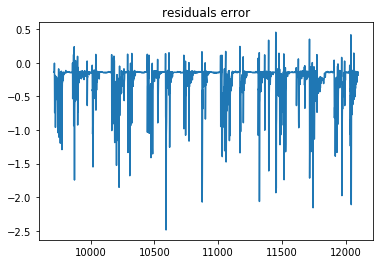

In [69]:
ax = sns.lineplot(data=error_distro['residuals'])
ax.set_title('residuals error')
error_distro['residuals'].describe()

Text(0.5, 1.0, 'Histogram Plot of Residual Errors')

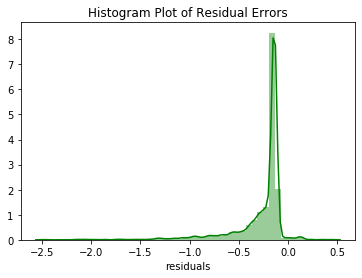

In [70]:
ax = sns.distplot(error_distro['residuals'], kde=True, color="g")
ax.set_title('Histogram Plot of Residual Errors')

In [71]:
residuals['DNN'] = error_distro['residuals']

In [72]:
del error_distro, actual_values, trainPredictPlot, testPredictPlot, dataset, lag, scaler, trainX, trainY, testX, testY

## LSTM autoencoders

In [128]:
def rnn_data(df, ts, look_back=1, train_fraction=0.80, Scaler=None):
    """
    Create data for modelling
    """

    # Convert an array of values into a dataset matrix
    def create_dataset(dataset, look_back=1):
        """
        Create the dataset
        """
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
        return np.array(dataX), np.array(dataY)
    
    # Get dataset
    dataset = df[ts].values
    dataset = dataset.astype('float32')
    
    # Normalize the dataset
    dataset = scaler.fit_transform(dataset.reshape(-1, 1))
    
    # Split into train and test sets
    train_size = int(len(dataset) * train_fraction)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
  
    # Reshape into X=t and Y=t+1
    look_back = look_back
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
  
    # Reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
    
    return trainX, trainY, testX, testY, dataset

In [129]:
# Initiate scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# window size
lag = 100

trainX, trainY, testX, testY, dataset = rnn_data(df=data_df, ts='meter_reading', look_back=lag, train_fraction=0.80, Scaler=scaler)

In [130]:
serie_size =  trainX.shape[1] # 12
n_features =  trainX.shape[2] # 1

epochs = 200
batch = 256
#lr = 0.0001

encoder_decoder = tf.keras.models.Sequential()
encoder_decoder.add(tf.keras.layers.LSTM(serie_size, activation='relu', input_shape=(serie_size, n_features), return_sequences=True))
encoder_decoder.add(tf.keras.layers.LSTM(6, activation='relu', return_sequences=True))
encoder_decoder.add(tf.keras.layers.LSTM(1, activation='relu'))
encoder_decoder.add(tf.keras.layers.RepeatVector(serie_size))
encoder_decoder.add(tf.keras.layers.LSTM(serie_size, activation='relu', return_sequences=True))
encoder_decoder.add(tf.keras.layers.LSTM(6, activation='relu', return_sequences=True))
encoder_decoder.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1)))
encoder_decoder.summary()

adam = tf.keras.optimizers.Adam(learning_rate=1e-4)
encoder_decoder.compile(loss='mse', optimizer=adam)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100, 100)          40800     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100, 6)            2568      
_________________________________________________________________
lstm_4 (LSTM)                (None, 1)                 32        
_________________________________________________________________
repeat_vector (RepeatVector) (None, 100, 1)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100, 100)          40800     
_________________________________________________________________
lstm_6 (LSTM)                (None, 100, 6)            2568      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 100, 1)           

In [131]:
rpt_vector_layer = tf.keras.Model(inputs=encoder_decoder.inputs, outputs=encoder_decoder.layers[3].output)
time_dist_layer = tf.keras.Model(inputs=encoder_decoder.inputs, outputs=encoder_decoder.layers[5].output)
encoder_decoder.layers

In [132]:
encoder = tf.keras.Model(inputs=encoder_decoder.inputs, outputs=encoder_decoder.layers[2].output)
#tf.keras.utils.plot_model(encoder_decoder, show_shapes=True, to_file='encoder_decoder_reconstruct_lstm.png')
#tf.keras.utils.plot_model(encoder, show_shapes=True, to_file='encoder_lstm.png')

In [133]:
train_encoded = encoder.predict(trainX)
test_encoded = encoder.predict(testX)
print('Encoded time-series shape', train_encoded.shape)
print('Encoded time-series sample', train_encoded[0])

Encoded time-series shape (9576, 1)
Encoded time-series sample [0.]


In [134]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))
train = pd.DataFrame(trainX)

testX = np.reshape(testX, (testX.shape[0], testX.shape[1]))
test = pd.DataFrame(testX)

In [135]:
train['encoded'] = train_encoded
train['label'] = trainY

test['encoded'] = validation_encoded
test['label'] = testY

In [136]:
last_month = serie_size - 1
Y_train_encoded = train['label']
train.drop('label', axis=1, inplace=True)
X_train_encoded = train[[last_month, 'encoded']]

Y_test_encoded = test['label']
test.drop('label', axis=1, inplace=True)
X_test_encoded = test[[last_month, 'encoded']]

print("Train set", X_train_encoded.shape)
print("Test set", X_test_encoded.shape)

Train set (9576, 2)
Test set (2319, 2)


In [120]:
X_train_encoded = X_train_encoded.values
X_test_encoded = X_test_encoded.values

Y_train_encoded = Y_train_encoded.values
Y_test_encoded = Y_test_encoded.values

In [121]:
epochs= 200
batch_size = 350

# reshape from [samples, time steps, features] into [samples, timesteps, features]
n_features = 1
trainX = X_train_encoded.reshape((X_train_encoded.shape[0], X_train_encoded.shape[1], n_features))
testX = X_test_encoded.reshape((X_test_encoded.shape[0], X_test_encoded.shape[1], n_features))
trainY = Y_train_encoded.reshape((Y_train_encoded.shape[0], n_features))
testY = Y_test_encoded.reshape((Y_test_encoded.shape[0], n_features))

tf.keras.backend.clear_session()

# Create and fit the LSTM network
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10, return_sequences=True, input_shape=[None, None, 1])))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10, return_sequences=True)))
#model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(25, activation='relu')))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(10, activation='relu')))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(5, activation='relu')))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='relu')))

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(loss='mse', optimizer=optimizer, metrics=[rmse, 'mae'])
early_stopping_monitor = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)

history = model.fit(trainX, trainY, epochs = epochs, batch_size = batch_size, verbose = 0, validation_split=0.1, callbacks = [early_stopping_monitor], shuffle=False, workers=0)

mlp_train_pred = model.predict(trainX, batch_size=batch_size, verbose=1)
mlp_test_pred = model.predict(testX, batch_size=batch_size, verbose=1)

2319/2319 [==============================] - 0s 9us/sample


In [126]:
mlp_test_pred

array([[[0.],
        [0.]],

       [[0.],
        [0.]],

       [[0.],
        [0.]],

       ...,

       [[0.],
        [0.]],

       [[0.],
        [0.]],

       [[0.],
        [0.]]], dtype=float32)

In [80]:
#Y_test = Y_test_encoded.to_numpy()
#Y_train = Y_train_encoded.to_numpy()

look_back = lag

# Invert predictions
#trainPredict = scaler.inverse_transform(mlp_train_pred.reshape((mlp_train_pred.shape[0],1)))
#trainY = scaler.inverse_transform(Y_train.reshape((Y_train.shape[0],1)))
testPredict = scaler.inverse_transform(mlp_test_pred.reshape((mlp_test_pred.shape[0],1)))
#testY = scaler.inverse_transform(Y_test.reshape((Y_test.shape[0],1)))

mae = metrics.mean_absolute_error(trainY,trainPredict)
mse = metrics.mean_squared_error(trainY,trainPredict)
print ("TRAINING SET")
print ("============")
print ("MAE:                ", mae)
print ("MSE:                ", mse)
print ("RMSE:               ", math.sqrt(mse))


mae = metrics.mean_absolute_error(testY,testPredict)
mse = metrics.mean_squared_error(testY,testPredict)
print ("TEST SET")
print ("========")
print ("MAE:                ", mae)
print ("MSE:                ", mse)
print ("RMSE:               ", math.sqrt(mse))

# #Shift train predictions for plotting
# trainPredictPlot = np.empty_like(dataset)
# trainPredictPlot[:, :] = np.nan
# trainPredictPlot[look_back:len(trainPredict)+lag, :] = trainPredict

# # Shift test predictions for plotting
# testPredictPlot = np.empty_like(dataset)
# testPredictPlot[:, :] = np.nan
# testPredictPlot[len(trainPredict)+(lag*2)+1:len(dataset)-1, :] = testPredict

# # Plot baseline and predictions
# plt.figure(figsize=(12,7))
# plt.plot(scaler.inverse_transform(dataset))
# plt.plot(trainPredictPlot)
# plt.plot(testPredictPlot)
# plt.vlines(x=9687, ymin=0, ymax=8, colors='k', linestyles='dashed')
# plt.title('train, test and real values')
# plt.show()

ValueError: cannot reshape array of size 4638 into shape (2319,1)

In [137]:
mlp_model = tf.keras.models.Sequential()
mlp_model.add(tf.keras.layers.Dense(5, kernel_initializer='glorot_normal', activation='relu', input_dim=X_train_encoded.shape[1]))
mlp_model.add(tf.keras.layers.Dense(10, kernel_initializer='glorot_normal', activation='relu'))
mlp_model.add(tf.keras.layers.Dense(20, kernel_initializer='glorot_normal', activation='relu'))
mlp_model.add(tf.keras.layers.Dense(10, kernel_initializer='glorot_normal', activation='relu'))
mlp_model.add(tf.keras.layers.Dense(5, kernel_initializer='glorot_normal', activation='relu'))
mlp_model.add(tf.keras.layers.Dense(1))
mlp_model.summary()

adam = tf.keras.optimizers.Adam(learning_rate=1e-4)
mlp_model.compile(loss='mse', optimizer=adam)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 5)                 15        
_________________________________________________________________
dense_6 (Dense)              (None, 10)                60        
_________________________________________________________________
dense_7 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_8 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 6         
Total params: 566
Trainable params: 566
Non-trainable params: 0
________________________________________________________

In [138]:
mlp_history = mlp_model.fit(X_train_encoded.values, Y_train_encoded.values, epochs=epochs, batch_size=batch, validation_split=0.1,  verbose=0)

In [139]:
mlp_test_pred = mlp_model.predict(X_test_encoded)
mlp_train_pred = mlp_model.predict(X_train_encoded)

In [105]:
Y_test = Y_test_encoded.to_numpy()
Y_train = Y_train_encoded.to_numpy()

look_back = lag

# Invert predictions
trainPredict = scaler.inverse_transform(mlp_train_pred.reshape((mlp_train_pred.shape[0],1)))
trainY = scaler.inverse_transform(Y_train.reshape((Y_train.shape[0],1)))
testPredict = scaler.inverse_transform(mlp_test_pred.reshape((mlp_test_pred.shape[0],1)))
testY = scaler.inverse_transform(Y_test.reshape((Y_test.shape[0],1)))

mae = metrics.mean_absolute_error(trainY,trainPredict)
mse = metrics.mean_squared_error(trainY,trainPredict)
print ("TRAINING SET")
print ("============")
print ("MAE:                ", mae)
print ("MSE:                ", mse)
print ("RMSE:               ", math.sqrt(mse))


mae = metrics.mean_absolute_error(testY,testPredict)
mse = metrics.mean_squared_error(testY,testPredict)
print ("TEST SET")
print ("========")
print ("MAE:                ", mae)
print ("MSE:                ", mse)
print ("RMSE:               ", math.sqrt(mse))

#Shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+lag, :] = trainPredict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(lag*2)+1:len(dataset)-1, :] = testPredict

# Plot baseline and predictions
plt.figure(figsize=(12,7))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.vlines(x=9687, ymin=0, ymax=8, colors='k', linestyles='dashed')
plt.title('train, test and real values')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

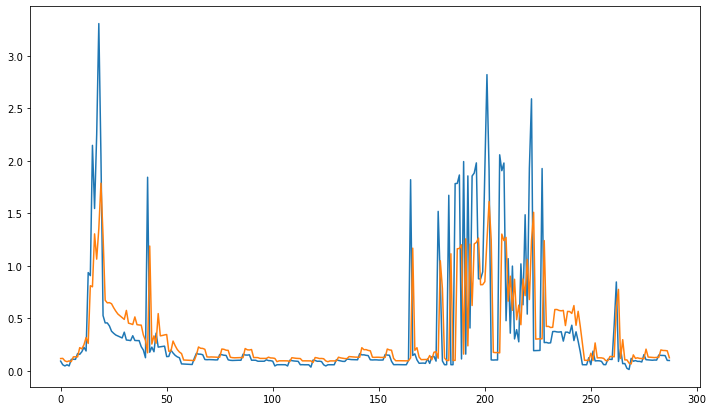

In [25]:
plt.figure(figsize=(12,7))
plt.plot(scaler.inverse_transform(dataset[10000:10288]))
#plt.plot(trainPredictPlot)
plt.plot(testPredictPlot[10000:10288])
#plt.vlines(x=9687, ymin=0, ymax=8, colors='k', linestyles='dashed')
#plt.title('train, test and real values')
plt.savefig('test_day.png', dpi=300)

plt.show()

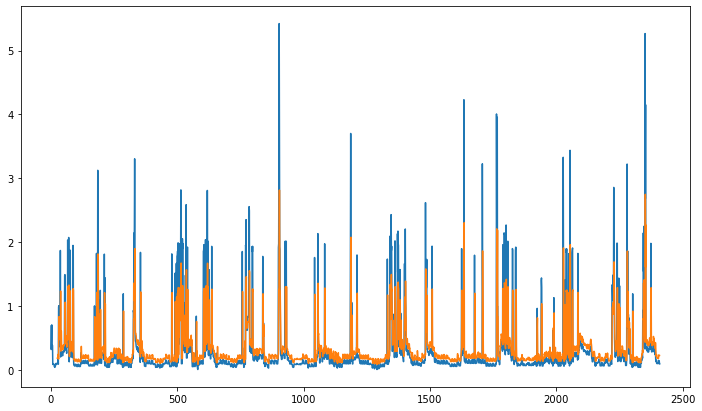

In [169]:
plt.figure(figsize=(12,7))
org = scaler.inverse_transform(dataset)
plt.plot(org[9687:])
plt.plot(testPredictPlot[9687:])
#plt.vlines(x=9687, ymin=0, ymax=8, colors='k', linestyles='dashed')
#plt.title('test and real values')
plt.show()

In [170]:
actual_values = dataset.flatten('F')
actual_values.reshape(-1, 1)
trainPredictPlot = trainPredictPlot.flatten('F')
trainPredictPlot.reshape(-1, 1)
testPredictPlot = testPredictPlot.flatten('F')
testPredictPlot.reshape(-1, 1)

array([[       nan],
       [       nan],
       [       nan],
       ...,
       [0.231871  ],
       [0.23065872],
       [       nan]], dtype=float32)

In [171]:
error_distro = pd.DataFrame(np.vstack((actual_values, testPredictPlot)))
error_distro = error_distro.transpose() 
error_distro.columns=['actual_value','testPredict']

error_distro.drop(error_distro.index[0:9687], inplace=True)
error_distro.drop(error_distro.index[len(error_distro)-1], inplace=True)
error_distro['residuals'] = error_distro['actual_value'] - error_distro['testPredict']

count    2384.000000
mean       -0.288688
std         0.279275
min        -2.344126
25%        -0.300167
50%        -0.196909
75%        -0.160079
max         0.430154
Name: residuals, dtype: float64

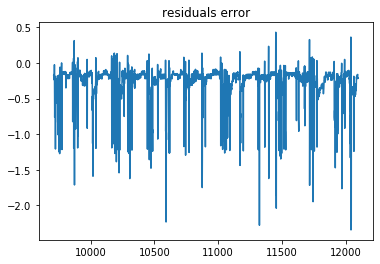

In [172]:
ax = sns.lineplot(data=error_distro['residuals'])
ax.set_title('residuals error')
error_distro['residuals'].describe()

Text(0.5, 1.0, 'Histogram Plot of Residual Errors')

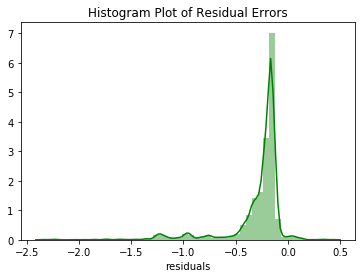

In [173]:
ax = sns.distplot(error_distro['residuals'], kde=True, color="g")
ax.set_title('Histogram Plot of Residual Errors')

## CNN-LSTM

In [8]:
def rnn_data(df, ts, look_back=1, train_fraction=0.80, Scaler=None):
    """
    Create data for modelling
    """

    # Convert an array of values into a dataset matrix
    def create_dataset(dataset, look_back=1):
        """
        Create the dataset
        """
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
        return np.array(dataX), np.array(dataY)
    
    # Get dataset
    dataset = df[ts].values
    dataset = dataset.astype('float32')
    
    # Normalize the dataset
    dataset = scaler.fit_transform(dataset.reshape(-1, 1))
    
    # Split into train and test sets
    train_size = int(len(dataset) * train_fraction)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
  
    # Reshape into X=t and Y=t+1
    look_back = look_back
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
  
    # Reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
    
    return trainX, trainY, testX, testY, dataset

In [49]:
# Initiate scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# window size
lag = 35

trainX, trainY, testX, testY, dataset = rnn_data(df=data_df, ts='meter_reading', look_back=lag, train_fraction=0.80, Scaler=scaler)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri multiple                  384       
_________________________________________________________________
time_distributed_1 (TimeDist multiple                  0         
_________________________________________________________________
time_distributed_2 (TimeDist multiple                  32896     
_________________________________________________________________
time_distributed_3 (TimeDist multiple                  0         
_________________________________________________________________
time_distributed_4 (TimeDist multiple                  0         
_________________________________________________________________
bidirectional (Bidirectional multiple                  1180672   
_________________________________________________________________
bidirectional_1 (Bidirection multiple                  3

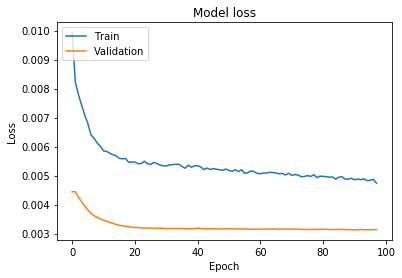

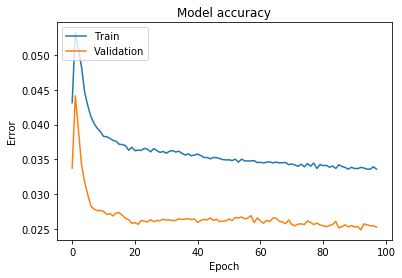

In [47]:
epochs= 200
batch_size = 350

# reshape from [samples, time steps, features] into [samples, subsequences, timesteps, features]
n_features = 1
n_seq = 1
trainX = trainX.reshape((trainX.shape[0], n_seq, lag, n_features))
testX = testX.reshape((testX.shape[0], n_seq, lag, n_features))

tf.keras.backend.clear_session()

# Create and fit the LSTM network
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(filters=128, kernel_size=2, input_shape=[None, None, 1])))
model.add(tf.keras.layers.TimeDistributed((tf.keras.layers.MaxPooling1D(pool_size=2))))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(filters=128, kernel_size=2)))
model.add(tf.keras.layers.TimeDistributed((tf.keras.layers.MaxPooling1D(pool_size=2))))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(50, kernel_initializer='glorot_normal', activation='relu')))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(25, kernel_initializer='glorot_normal', activation='relu')))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(10, kernel_initializer='glorot_normal', activation='relu')))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, kernel_initializer='glorot_normal', activation='relu')))

#lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(loss='mse', optimizer=optimizer, metrics=[rmse, 'mae'])
early_stopping_monitor = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)

history = model.fit(trainX, trainY, epochs = epochs, batch_size = batch_size, verbose = 0, validation_split=0.1, callbacks = [early_stopping_monitor], shuffle=False, workers=0)

#print('Loss (MSE):', history.history['loss'][-1], '\nVal_loss (MSE):', history.history['val_loss'][-1])
# score_rmse_train = model.evaluate(trainX, trainY, verbose = 0)
# score_rmse_test = model.evaluate(testX, testY, verbose = 0)
# print('Train Score (MSE, RMSE, MAE):', score_rmse_train)
# print('Test Score (MSE, RMSE, MAE):', score_rmse_test)

model.summary()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('Model accuracy')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

2384/2384 [==============================] - 0s 169us/sample
TRAINING SET
MAE:                 0.19821468
MSE:                 0.19851235
RMSE:                0.44554724278402225
TEST SET
MAE:                 0.19327824
MSE:                 0.21488968
RMSE:                0.4635619434108018


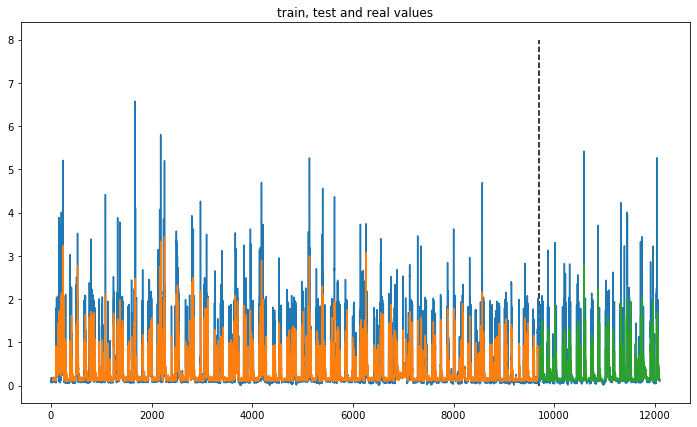

In [48]:
# Make predictions
trainPredict = model.predict(trainX, batch_size=batch_size, verbose=1)
testPredict = model.predict(testX, batch_size=batch_size, verbose=1)
look_back = lag
    
# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict.reshape((trainPredict.shape[0],1)))
trainY = scaler.inverse_transform(trainY.reshape((trainY.shape[0],1)))
testPredict = scaler.inverse_transform(testPredict.reshape((testPredict.shape[0],1)))
testY = scaler.inverse_transform(testY.reshape((testY.shape[0],1)))

mae = metrics.mean_absolute_error(trainY,trainPredict)
mse = metrics.mean_squared_error(trainY,trainPredict)
print ("TRAINING SET")
print ("============")
print ("MAE:                ", mae)
print ("MSE:                ", mse)
print ("RMSE:               ", math.sqrt(mse))


mae = metrics.mean_absolute_error(testY,testPredict)
mse = metrics.mean_squared_error(testY,testPredict)
print ("TEST SET")
print ("========")
print ("MAE:                ", mae)
print ("MSE:                ", mse)
print ("RMSE:               ", math.sqrt(mse))

# Shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+lag, :] = trainPredict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(lag*2)+1:len(dataset)-1, :] = testPredict

# Plot baseline and predictions
plt.figure(figsize=(12,7))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.vlines(x=9687, ymin=0, ymax=8, colors='k', linestyles='dashed')
plt.title('train, test and real values')
plt.show()

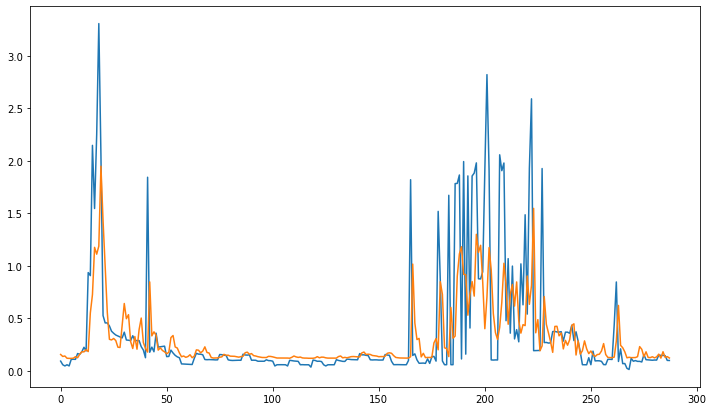

In [133]:
plt.figure(figsize=(12,7))
plt.plot(scaler.inverse_transform(dataset[10000:10288]))
#plt.plot(trainPredictPlot)
plt.plot(testPredictPlot[10000:10288])
#plt.vlines(x=9687, ymin=0, ymax=8, colors='k', linestyles='dashed')
#plt.title('train, test and real values')
plt.savefig('test_day.png', dpi=300)

plt.show()

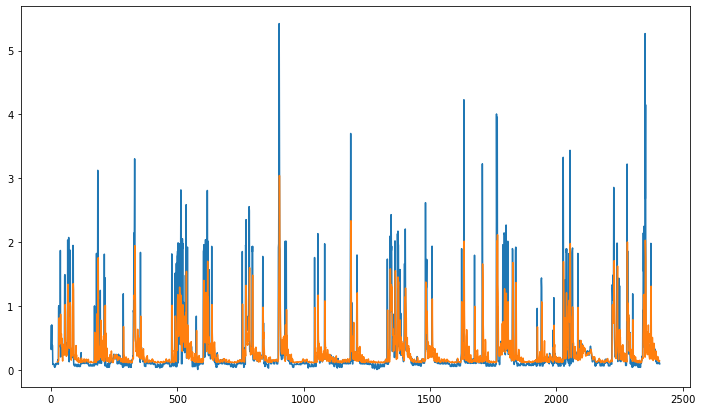

In [134]:
plt.figure(figsize=(12,7))
org = scaler.inverse_transform(dataset)
plt.plot(org[9687:])
plt.plot(testPredictPlot[9687:])
#plt.vlines(x=9687, ymin=0, ymax=8, colors='k', linestyles='dashed')
#plt.title('test and real values')
plt.show()

In [92]:
actual_values = dataset.flatten('F')
actual_values.reshape(-1, 1)
trainPredictPlot = trainPredictPlot.flatten('F')
trainPredictPlot.reshape(-1, 1)
testPredictPlot = testPredictPlot.flatten('F')
testPredictPlot.reshape(-1, 1)

array([[      nan],
       [      nan],
       [      nan],
       ...,
       [1.0097525],
       [0.961365 ],
       [      nan]], dtype=float32)

In [93]:
error_distro = pd.DataFrame(np.vstack((actual_values, testPredictPlot)))
error_distro = error_distro.transpose() 
error_distro.columns=['actual_value','testPredict']

error_distro.drop(error_distro.index[0:9687], inplace=True)
error_distro.drop(error_distro.index[len(error_distro)-1], inplace=True)
error_distro['residuals'] = error_distro['actual_value'] - error_distro['testPredict']

count    2384.000000
mean       -1.785637
std         1.827102
min       -18.065979
25%        -1.763138
50%        -0.968787
75%        -0.897290
max        -0.293530
Name: residuals, dtype: float64

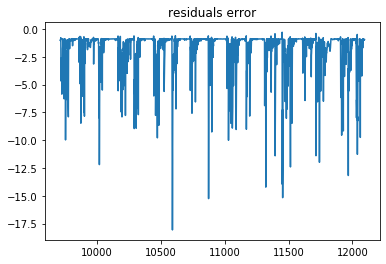

In [94]:
ax = sns.lineplot(data=error_distro['residuals'])
ax.set_title('residuals error')
error_distro['residuals'].describe()

Text(0.5, 1.0, 'Histogram Plot of Residual Errors')

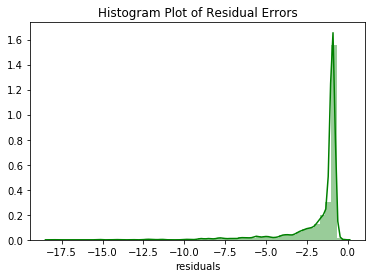

In [95]:
ax = sns.distplot(error_distro['residuals'], kde=True, color="g")
ax.set_title('Histogram Plot of Residual Errors')

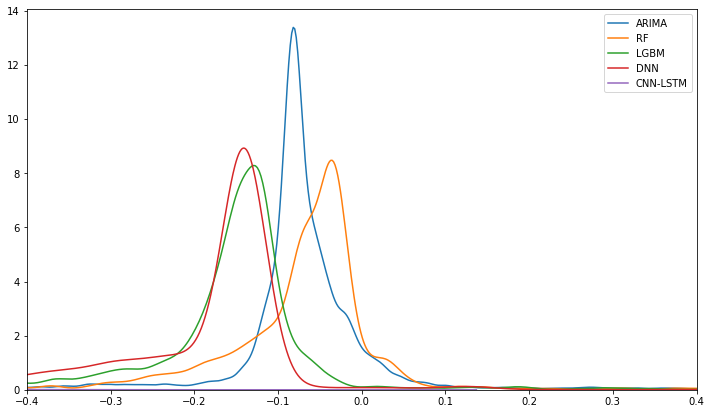

In [96]:
residuals['CNN-LSTM'] = error_distro['residuals']

# Sort the dataframe by target
target_0 = residuals['ARIMA']
target_1 = residuals['RF']
target_2 = residuals['LGBM']
target_3 = residuals['DNN']
target_4 = residuals['CNN-LSTM']

plt.figure(figsize=(12,7))

#sns.distplot(target_0, hist=False, kde_kws={"label": "ARIMA"})
#sns.distplot(target_1, hist=False, kde_kws={"label": "RF"})
#sns.distplot(target_2, hist=False, kde_kws={"label": "LGBM"})
#sns.distplot(target_3, hist=False, kde_kws={"label": "CNN-LSTM"})
sns.kdeplot(target_0, gridsize=3000)
sns.kdeplot(target_1, gridsize=3000)
sns.kdeplot(target_2, gridsize=3000)
sns.kdeplot(target_3, gridsize=3000)
sns.kdeplot(target_4, gridsize=3000)

plt.xlim(-0.4, 0.4)

plt.savefig('pdf.png', dpi=300)

#ax = sns.distplot(residuals[])

In [97]:
del error_distro, actual_values, trainPredictPlot, testPredictPlot, dataset, lag, scaler, trainX, trainY, testX, testY

## Test on another building (C24)

In [20]:
# loading the data from onedrive
# change the name for different house
data_c24 = pd.read_csv('C:/Users/al146/OneDrive - Heriot-Watt University/PhD/Data/Findhorn/test/C24_15Feb2015_28Mar2015.csv', names=['date', 'time', 'meter_reading'], skiprows=1)
data_c24["timestamp"] = data_c24["date"] + " " + data_c24["time"].astype(str)
data_c24['timestamp'] = pd.to_datetime(data_c24['timestamp'], errors='raise', infer_datetime_format=True)
data_c24 = data_c24.drop(['time', 'date'], axis=1)
data_c24['site_id'] = 'c24'

In [21]:
# Loading data (Reading and cleaning the files)

data_c24 = reduce_mem_usage(data_c24.copy())

data_c24['site_id'] = data_c24['site_id'].astype('str')
data_c24['timestamp'] = pd.to_datetime(data_c24['timestamp'], errors='raise')

# replace negative values with a small number
data_c24['meter_reading'].mask(data_c24['meter_reading'] <= 0, 0.09, inplace=True)

data_c24.drop(data_c24.columns[2], axis=1, inplace=True)

Mem. usage decreased to  0.21 Mb (25.0% reduction)


In [22]:
def test_data(df, ts, look_back=1, Scaler=None):
    """
    Create data for modelling
    """

    # Convert an array of values into a dataset matrix
    def create_dataset(dataset, look_back=1):
        """
        Create the dataset
        """
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
        return np.array(dataX), np.array(dataY)
    
    # Get dataset
    dataset = df[ts].values
    dataset = dataset.astype('float32')
    
    # Normalize the dataset
    #dataset = scaler.fit_transform(dataset.reshape(-1, 1))
    dataset = dataset.reshape(-1, 1)
    
    # Reshape into X=t and Y=t+1
    look_back = look_back
    testX, testY = create_dataset(dataset, look_back)
  
    # Reshape input to be [samples, time steps, features]
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
    
    return testX, testY, dataset

In [23]:
#scaler = MinMaxScaler(feature_range=(0, 1))

# window size
lag = 35

testX, testY, dataset = test_data(df=data_c24, ts='meter_reading', look_back=lag, Scaler=scaler)

In [24]:
testX = testX.reshape((testX.shape[0], n_seq, lag, n_features))

#score_rmse_test = model.evaluate(testX, testY, verbose = 0)
#print('Test Score (MSE, RMSE):', score_rmse_test)

In [25]:
# Make predictions
testPredict = model.predict(testX, batch_size=256, verbose=1)
look_back = lag
    
#testPredict = scaler.inverse_transform(testPredict.reshape((testPredict.shape[0],1)))
testPredict = testPredict.reshape((testPredict.shape[0],1))
#testY = scaler.inverse_transform(testY.reshape((testY.shape[0],1)))
testY = testY.reshape((testY.shape[0],1))

mae = metrics.mean_absolute_error(testY,testPredict)
mse = metrics.mean_squared_error(testY,testPredict)
print ("TEST SET")
print ("========")
print ("MAE:                ", mae)
print ("MSE:                ", mse)
print ("RMSE:               ", math.sqrt(mse))

# Shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[lag+1:len(dataset), :] = testPredict

12061/12061 [==============================] - 1s 107us/sample
TEST SET
MAE:                 0.18026687
MSE:                 0.1519173
RMSE:                0.38976569072686895


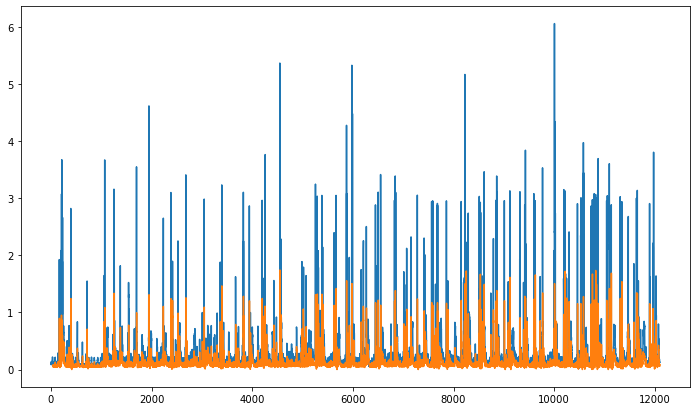

In [77]:
# Plot baseline and predictions
plt.figure(figsize=(12,7))
#plt.plot(scaler.inverse_transform(dataset))
plt.plot(dataset)
#plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.savefig('c24_test.png', dpi=300)
plt.show()

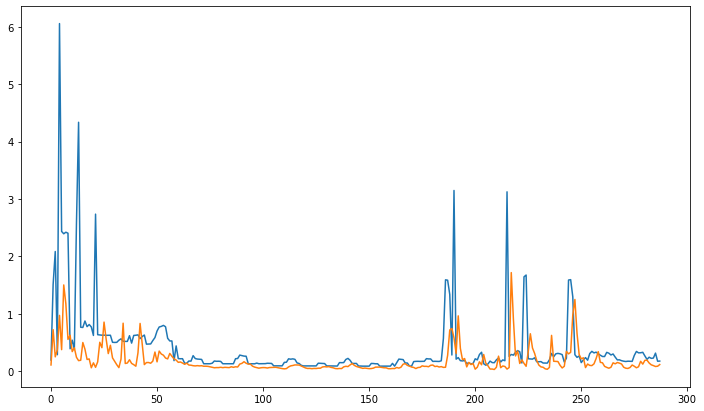

In [78]:
plt.figure(figsize=(12,7))
plt.plot(dataset[10000:10288])
#plt.plot(trainPredictPlot)
plt.plot(testPredictPlot[10000:10288])
#plt.vlines(x=9687, ymin=0, ymax=8, colors='k', linestyles='dashed')
#plt.title('train, test and real values')
plt.savefig('c24_test.png', dpi=300)

plt.show()